# Run Pharaglow 

In [12]:
%matplotlib inline
import numpy as np
import pandas as pd
# image io and analysis
import json
import pims
import trackpy as tp
# plotting
import matplotlib  as mpl 
import matplotlib.pyplot as plt 

#our packages
from pharaglow import tracking, run, features

### Load data and create binary masks 

In [13]:
%%time
# io
fname = "/media/scholz_la/hd2/Nicolina/Nicolina/20200109_NZ0017/*.tiff"
parameterfile = "/media/scholz_la/hd2/Nicolina/Nicolina/pharaglow_parameters_mks.txt"
outfile = "/media/scholz_la/hd2/Nicolina/Nicolina/20200109_NZ0017_{}_{}.json"
print('Starting pharaglow analysis...')
rawframes = pims.open(fname)
rawframes = rawframes[0:18000]
#print('Analyzing', rawframes)
print('Loading parameters from {}'.format(parameterfile.split('/')[-2:]))
with open(parameterfile) as f:
    param = json.load(f)


Starting pharaglow analysis...


/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/pims/api.py:191: UserWarning: <class 'pims.tiff_stack.TiffStack_tifffile'> errored: [Errno 2] No such file or directory: '/media/scholz_la/hd2/Nicolina/Nicolina/20200109_NZ0017/*.tiff'
  warn(message)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/pims/api.py:191: UserWarning: <class 'pims.imageio_reader.ImageIOReader'> errored: No such file: '/media/scholz_la/hd2/Nicolina/Nicolina/20200109_NZ0017/*.tiff'
  warn(message)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/pims/api.py:191: UserWarning: <class 'pims.bioformats.BioformatsReader'> errored: The file "/media/scholz_la/hd2/Nicolina/Nicolina/20200109_NZ0017/*.tiff" does not exist.
  warn(message)


UnknownFormatError: All handlers returned exceptions:
<class 'pims.tiff_stack.TiffStack_tifffile'> errored: [Errno 2] No such file or directory: '/media/scholz_la/hd2/Nicolina/Nicolina/20200109_NZ0017/*.tiff'
<class 'pims.imageio_reader.ImageIOReader'> errored: No such file: '/media/scholz_la/hd2/Nicolina/Nicolina/20200109_NZ0017/*.tiff'
<class 'pims.bioformats.BioformatsReader'> errored: The file "/media/scholz_la/hd2/Nicolina/Nicolina/20200109_NZ0017/*.tiff" does not exist.


In [ ]:
%%time
# detecting objects
print('Binarizing images')
masks = tracking.calculateMask(rawframes, minSize = param['minSize'], bgWindow = 100, thresholdWindow = 100, smooth = 3, subtract = 1)


### Make sure the thesholding worked otherwise change parameters

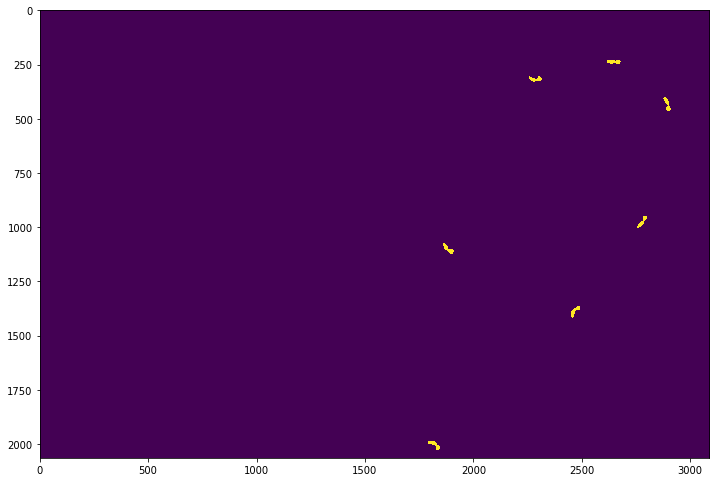

In [16]:
t = 1010
plt.figure(figsize=(12,11))
# plt.subplot(121)
# plt.imshow(rawframes[t])
# plt.subplot(122)
plt.imshow(masks[t])
#plt.imshow(masks[t][ 250:750, 1800:2000])
#plt.imshow(masks[t][1500:2000, 1000:2750])

#np.sum(masks[t][500:750, 1000:1500])
#print(np.sum(masks[t][ 350:750, 1600:2000]))

#image = masks[t][ 350:750, 1600:2000]
#labeled = tracking.refine(image, size = param['watershed'])
#plt.imshow(labeled)

### Detecting individual objects and tracking or use multiprocessing to speed up feature detection

In [17]:
%%time
import time

nWorkers = 20
if nWorkers ==1:

    #masks = tracking.preprocess(rawframes, minSize = param['minSize'], threshold =None )
    print('Detecting features')
    features = tracking.runfeatureDetection(rawframes, masks, param, frameOffset = 0)
else:
    from multiprocessing import Pool
    print('Detecting features')
    def f(sl):
        a,b = sl
        #print(a,b)
        return tracking.runfeatureDetection(rawframes[a:b], masks[a:b], param, frameOffset = a)
    features = []
    L = len(rawframes)
    # create chunks of analysis based on how many workers we use
    print(L)
    chunksize = L//nWorkers//20
    #slices = np.arange(L)
    slices = zip((range(0,L, chunksize)), (range(chunksize,L+chunksize, chunksize)))
    
    p = Pool(20)
    start = time.time()
    for res in p.imap_unordered(f, slices):
        features.append(res)
        print(p, time.time()-start)
    features = pd.concat(features)

Detecting features
18000
<multiprocessing.pool.Pool object at 0x7f22a39bd438> 257.8597369194031
<multiprocessing.pool.Pool object at 0x7f22a39bd438> 258.0277044773102
<multiprocessing.pool.Pool object at 0x7f22a39bd438> 258.0744950771332
<multiprocessing.pool.Pool object at 0x7f22a39bd438> 258.64107871055603
<multiprocessing.pool.Pool object at 0x7f22a39bd438> 258.72026443481445
<multiprocessing.pool.Pool object at 0x7f22a39bd438> 259.895224571228
<multiprocessing.pool.Pool object at 0x7f22a39bd438> 264.729127407074
<multiprocessing.pool.Pool object at 0x7f22a39bd438> 265.40243220329285
<multiprocessing.pool.Pool object at 0x7f22a39bd438> 266.5090470314026
<multiprocessing.pool.Pool object at 0x7f22a39bd438> 266.5300507545471
<multiprocessing.pool.Pool object at 0x7f22a39bd438> 266.64161252975464
<multiprocessing.pool.Pool object at 0x7f22a39bd438> 266.6771717071533
<multiprocessing.pool.Pool object at 0x7f22a39bd438> 266.8707137107849
<multiprocessing.pool.Pool object at 0x7f22a39bd43

<multiprocessing.pool.Pool object at 0x7f22a39bd438> 1329.6104233264923
<multiprocessing.pool.Pool object at 0x7f22a39bd438> 1335.5416486263275
<multiprocessing.pool.Pool object at 0x7f22a39bd438> 1339.5830421447754
<multiprocessing.pool.Pool object at 0x7f22a39bd438> 1345.8812718391418
<multiprocessing.pool.Pool object at 0x7f22a39bd438> 1433.8503637313843
<multiprocessing.pool.Pool object at 0x7f22a39bd438> 1440.5241222381592
<multiprocessing.pool.Pool object at 0x7f22a39bd438> 1441.0769860744476
<multiprocessing.pool.Pool object at 0x7f22a39bd438> 1446.8037993907928
<multiprocessing.pool.Pool object at 0x7f22a39bd438> 1450.177907705307
<multiprocessing.pool.Pool object at 0x7f22a39bd438> 1451.3569631576538
<multiprocessing.pool.Pool object at 0x7f22a39bd438> 1451.8595442771912
<multiprocessing.pool.Pool object at 0x7f22a39bd438> 1452.024647951126
<multiprocessing.pool.Pool object at 0x7f22a39bd438> 1452.058137178421
<multiprocessing.pool.Pool object at 0x7f22a39bd438> 1453.005243301

<multiprocessing.pool.Pool object at 0x7f22a39bd438> 2192.794103384018
<multiprocessing.pool.Pool object at 0x7f22a39bd438> 2193.58034658432
<multiprocessing.pool.Pool object at 0x7f22a39bd438> 2193.8973672389984
<multiprocessing.pool.Pool object at 0x7f22a39bd438> 2193.908357858658
<multiprocessing.pool.Pool object at 0x7f22a39bd438> 2194.1536469459534
<multiprocessing.pool.Pool object at 0x7f22a39bd438> 2198.9356236457825
<multiprocessing.pool.Pool object at 0x7f22a39bd438> 2202.553297996521
<multiprocessing.pool.Pool object at 0x7f22a39bd438> 2211.268899202347
<multiprocessing.pool.Pool object at 0x7f22a39bd438> 2342.390254497528
<multiprocessing.pool.Pool object at 0x7f22a39bd438> 2354.6685678958893
<multiprocessing.pool.Pool object at 0x7f22a39bd438> 2354.966293334961
<multiprocessing.pool.Pool object at 0x7f22a39bd438> 2355.1011366844177
<multiprocessing.pool.Pool object at 0x7f22a39bd438> 2360.439806699753
<multiprocessing.pool.Pool object at 0x7f22a39bd438> 2360.6847434043884
<

<multiprocessing.pool.Pool object at 0x7f22a39bd438> 3372.4711694717407
<multiprocessing.pool.Pool object at 0x7f22a39bd438> 3379.602998495102
<multiprocessing.pool.Pool object at 0x7f22a39bd438> 3379.6562991142273
<multiprocessing.pool.Pool object at 0x7f22a39bd438> 3381.5813636779785
<multiprocessing.pool.Pool object at 0x7f22a39bd438> 3381.6205399036407
<multiprocessing.pool.Pool object at 0x7f22a39bd438> 3381.970555305481
<multiprocessing.pool.Pool object at 0x7f22a39bd438> 3385.0075163841248
<multiprocessing.pool.Pool object at 0x7f22a39bd438> 3393.0435316562653
<multiprocessing.pool.Pool object at 0x7f22a39bd438> 3398.8177111148834
<multiprocessing.pool.Pool object at 0x7f22a39bd438> 3399.603692293167
<multiprocessing.pool.Pool object at 0x7f22a39bd438> 3399.738674402237
<multiprocessing.pool.Pool object at 0x7f22a39bd438> 3405.3723442554474
<multiprocessing.pool.Pool object at 0x7f22a39bd438> 3425.7482035160065
<multiprocessing.pool.Pool object at 0x7f22a39bd438> 3564.4423871040

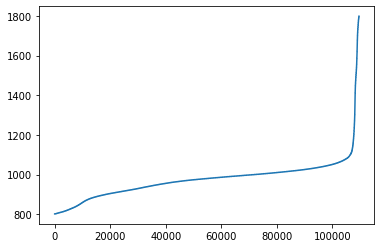

In [18]:

### Save the features
plt.plot(np.sort(features['area'].values))

In [3]:
features.head(5)
features.info(memory_usage='deep')
features.to_json(outfile.format('features', 'all'), orient='split')

AttributeError: module 'pharaglow.features' has no attribute 'head'

In [3]:
#features = pd.read_json(outfile.format('features'), orient='split', numpy = True)

In [4]:
print('Done')
print('Linking trajectories')
#trajectories = tracking.linkParticles(features, param['searchRange'], param['minimalDuration'])
#trajectories = tracking.linkParticles(features, 50, 500);
#trajectories = tp.link_df(features, 50, memory= 30)
#trajectories = tp.filter_stubs(trajectories,100)
pred = tp.predict.NearestVelocityPredict()
trajectories = pred.link_df(features, 40, memory= 300)

Frame 17999: 5 trajectories present.


In [5]:
print(trajectories['particle'].nunique())
trajectories = tp.filter_stubs(trajectories,500)
print(trajectories['particle'].nunique())

99
30


### Show resulting trajectories

In [6]:
plt.figure(figsize=(11,11))
tp.plot_traj(trajectories, superimpose=1-masks[900]);

NameError: name 'masks' is not defined

<Figure size 792x792 with 0 Axes>

In [7]:
from multiprocessing import Pool
def parallelize_dataframe(df, func, params, n_cores):
    df_split = np.array_split(df, n_cores)
    print([len(d) for d in df_split])
    pool = Pool(n_cores)
    df = pd.concat(pool.starmap(func, zip(df_split, np.repeat(params, len(df_split)))))
    pool.close()
    pool.join()
    return df

### run the whole pharaglow feature extraction

In [10]:
%%time
print('Extracting pharynx data')
trajectories = parallelize_dataframe(trajectories, run.runPharaglowOnStack, n_cores = 20, params = param)
print('Done tracking. Successfully tracked {} frames with {} trajectorie(s).'.format(len(rawframes), trajectories['particle'].nunique()))

Extracting pharynx data
[5108, 5108, 5108, 5108, 5108, 5108, 5108, 5108, 5108, 5108, 5108, 5107, 5107, 5107, 5107, 5107, 5107, 5107, 5107, 5107]
Done tracking. Successfully tracked 18000 frames with 30 trajectorie(s).
CPU times: user 32.1 s, sys: 10.4 s, total: 42.4 s
Wall time: 39min 16s


### Save data as hdf5 format (every trajectory in a file)

In [11]:
#trajectories.info(memory_usage='deep')
for particle_index in trajectories['particle'].unique():
    trajectories[trajectories.loc[:,'particle'] == particle_index].to_json(outfile.format('results', particle_index), orient='split')